In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, balanced_accuracy_score

from manuscript_functions.model_utils import find_and_load_checkpoint, preprocess, get_run_meta
from manuscript_functions.model_evaluation import get_blast_prop
from manuscript_functions.colors import patient_to_id, timepoints_cmap, default_rgba

/Users/adr/miniconda3/envs/PE_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sns.set_theme(font="Arial", style="ticks", rc={"font.size": 8,"axes.titlesize":8,"axes.labelsize":8, 
                                               "xtick.labelsize": 8, "ytick.labelsize": 8})
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams['font.size'] = 8

In [3]:
all_expr = "/Users/adr/Box/iPC_work/Local_files_for_paper/Updated/Raw/myeloid_expr_raw.csv"
all_meta = "/Users/adr/Box/iPC_work/Local_files_for_paper/Updated/local_all_cells_meta_clust_celltype.csv"
run_dir = "/Users/adr/Box/iPC_work/Local_files_for_paper/Model/Choosen_model/autoencoder_0.9/"

run_meta = get_run_meta(run_id=None, runs=None, client=None, 
                        expr_file=all_expr, meta_file=all_meta, 
                        thresh_mix_file=None, thresh_mix_meta=None,
                        inc_rel_error=False, old_CV=False, transform_syn_mix=True,
                        run_dir=run_dir)
run_meta["PatientID"] = [patient_to_id[p] for p  in run_meta["patient_id"]]

In [4]:
# Load predictions
path = "/Users/adr/Box/iPC_work/Local_files_for_paper/Model/Experiments/sklear_models/LCO/L1O/"
svm_pred = np.load(f"{path}svm_prediction.npy")

In [5]:
trans_norm_expr = pd.read_csv("/Users/adr/Box/iPC_work/Local_files_for_paper/Updated/Transformed_normalised/myeloid_expr_transformed_normalised.csv",
                             index_col=0)
CD45_thresh = 0.417

CD45_low = ["Blast" if CD45 < CD45_thresh else "Healthy" for CD45 in trans_norm_expr["CD45"] ]



In [6]:
run_meta["Prediction"] = svm_pred
run_meta["CD45_pred"] = CD45_low
run_meta.loc[svm_pred==CD45_low, "Agree"] = [pred for idx, pred in enumerate(svm_pred) if pred==CD45_low[idx]]

In [7]:
run_meta

,time_point,patient_id,file_id,cluster_id,healthy_cluster,cell_type,nh_cluster,mse,Prediction,UMAP1,UMAP2,enc1,enc2,enc3,enc4,PatientID,CD45_pred,Agree
0,Diagnosis,PAUMTZ,0,20,NaN,Pro-Monocyte?,20.0,0.017091,Blast,-1.936706,4.981234,0.086321,-0.405830,0.064351,-0.156649,P1,Healthy,NaN
1,Diagnosis,PAUMTZ,0,20,NaN,Pro-Monocyte?,20.0,0.019936,Healthy,-0.554209,3.329392,-0.228653,-0.420474,-0.192542,-0.136873,P1,Healthy,Healthy
2,Diagnosis,PAUMTZ,0,20,NaN,Pro-Monocyte?,20.0,0.015560,Healthy,-0.984189,11.663635,0.115687,-0.601863,0.505226,0.015340,P1,Healthy,Healthy
3,Diagnosis,PAUMTZ,0,20,NaN,Pro-Monocyte?,20.0,0.022286,Blast,-5.242311,2.161000,0.317947,-0.777660,0.318589,0.266440,P1,Healthy,NaN
4,Diagnosis,PAUMTZ,0,20,NaN,Pro-Monocyte?,20.0,0.003863,Healthy,8.167148,5.914129,-0.711251,0.459058,-0.440667,-0.254009,P1,Blast,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350245,EOI I,TEST12378,42,23,6.0,Monocyte,NaN,0.010354,Healthy,0.294297,7.996408,0.046913,-0.432760,0.243133,0.730975,P21,Healthy,Healthy
350246,EOI I,TEST12378,42,23,6.0,Monocyte,NaN,0.002881,Healthy,-0.202658,7.899752,0.365541,-0.826888,0.187653,0.591443,P21,Healthy,Healthy
350247,EOI I,TEST12378,42,23,6.0,Monocyte,NaN,0.004404,Healthy,-5.668076,1.274266,0.301370,-1.094499,0.251027,0.323422,P21,Healthy,Healthy
350248,EOI I,TEST12378,42,23,6.0,Monocyte,NaN,0.005211,Healthy,0.277729,8.232510,0.396084,-0.699730,0.357821,1.029119,P21,Healthy,Healthy


In [8]:
svm_frac = get_blast_prop(run_meta, full_file_size=True, pred_col_name="Prediction").rename(columns={"prop": "svm_prop",
                                                                                                    "counts": "svm_counts"})
CD45_frac = get_blast_prop(run_meta, full_file_size=True, pred_col_name="CD45_pred").rename(columns={"prop": "CD45_prop",
                                                                                                    "counts": "CD45_counts",
                                                                                                    "CD45_pred": "Prediction"})
CD45_of_svm_frac = get_blast_prop(run_meta, full_file_size=True, pred_col_name="Agree").rename(columns={"prop": "Agree_prop",
                                                                                                    "counts": "Agree_counts",
                                                                                                    "Agree": "Prediction"})


all_frac = pd.merge(svm_frac, CD45_frac, 
                    on=["file_id", "time_point", "PatientID", "size", "Prediction"]).merge(CD45_of_svm_frac, 
                                                                                           on=["file_id", "time_point", "PatientID", "size", "Prediction"])

all_frac["Agree_prop"] = all_frac["Agree_counts"]/all_frac["svm_counts"]
all_frac = all_frac.sort_values(["PatientID", "time_point"], key=lambda idx: [int(x.replace("P", "")) if idx.name=="PatientID"  else x for x in idx])
all_frac["perc_diff"] = (all_frac["svm_prop"] - all_frac["CD45_prop"])*100
all_frac

,file_id,time_point,PatientID,size,Prediction,svm_counts,svm_prop,CD45_counts,CD45_prop,Agree_counts,Agree_prop,perc_diff
0,0,Diagnosis,P1,10000,Blast,4994,0.4994,4781,0.4781,2766,0.553865,2.13
1,0,Diagnosis,P1,10000,Healthy,4419,0.4419,4632,0.4632,2404,0.544014,-2.13
2,1,Relapse,P1,10000,Blast,6610,0.6610,7181,0.7181,5036,0.761876,-5.71
3,1,Relapse,P1,10000,Healthy,2593,0.2593,2022,0.2022,448,0.172773,5.71
18,9,Diagnosis,P2,10000,Blast,8829,0.8829,8879,0.8879,8760,0.992185,-0.50
...,...,...,...,...,...,...,...,...,...,...,...,...
67,33,Diagnosis,P20,10000,Healthy,3402,0.3402,451,0.0451,225,0.066138,29.51
68,34,Relapse,P20,10000,Blast,9080,0.9080,9060,0.9060,8999,0.991079,0.20
69,34,Relapse,P20,10000,Healthy,77,0.0077,97,0.0097,16,0.207792,-0.20
84,42,EOI I,P21,10000,Blast,206,0.0206,539,0.0539,27,0.131068,-3.33


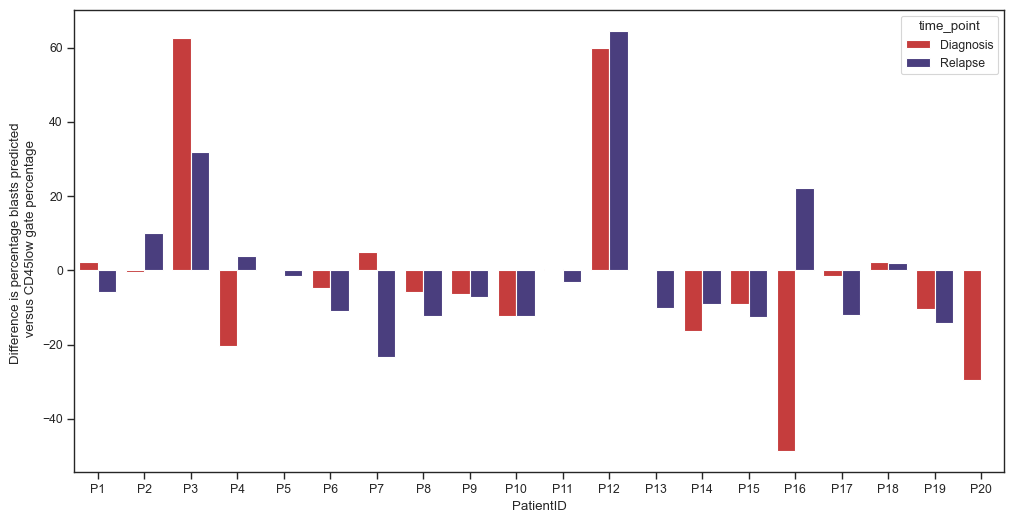

In [23]:
plt.figure(figsize=(12,6))
sns.barplot(data=all_frac[(all_frac["Prediction"]=="Blast")&(all_frac["time_point"]!="EOI I")], 
            x="PatientID", y="perc_diff", hue="time_point", 
            palette=timepoints_cmap)
plt.ylabel("Difference is percentage blasts predicted \n versus CD45low gate percentage")
plt.savefig("/Users/adr/Box/iPC_AML/Documents/Manuscript/Figures/Figure2/compare_svm_CD45low_frac.pdf")

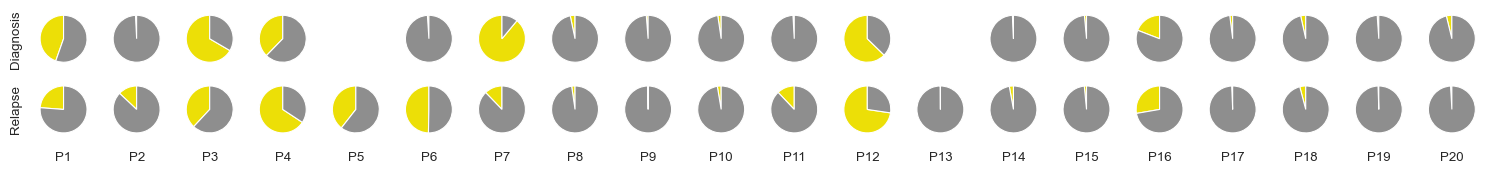

In [38]:
loop_data = all_frac.loc[all_frac["time_point"]!="EOI I", 
                         ["PatientID", "time_point"]].drop_duplicates().reset_index(drop=True)

fig, axes = plt.subplots(2, 20, figsize=(15,1.8))
fig.delaxes(ax= axes[0,4]) # Missing diagnosis sample
fig.delaxes(ax= axes[0,12]) # Missing diagnsis sample
for i, (patient, time) in loop_data.iterrows():
#     print(i, patient, time)
    patient_num = int(patient.replace("P", ""))
    if time=="Diagnosis":
        ax = axes[0, patient_num-1]
#         print(time, 1, patient_num-1)
    if time=="Relapse":
        ax = axes[1, patient_num-1]
#         print(time, 0, patient_num-1)
        
    
    temp = all_frac.loc[(all_frac["PatientID"]==patient)&(all_frac["time_point"]==time)&(all_frac["Prediction"]=="Blast"), 
                    ["Agree_prop", "svm_prop"]]
    
    CD45high_frac=temp["Agree_prop"].values[0]
    svm_prop = temp["svm_prop"].values[0]
    ax.pie([1-CD45high_frac, CD45high_frac],  
           colors=[default_rgba["yellow"], default_rgba["grey"]], 
           startangle=90)
    if time=="Relapse":
        ax.set_xlabel(patient)
        if patient_num==1:
            ax.set_ylabel("Relapse")
    elif patient_num==1:
        ax.set_ylabel("Diagnosis")

plt.tight_layout()
plt.savefig("/Users/adr/Box/iPC_AML/Documents/Manuscript/Figures/Figure2/pie_chart_plot.pdf")



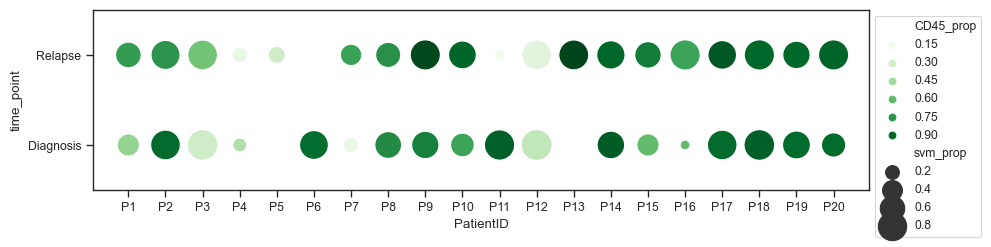

In [11]:
plt.figure(figsize=(10,2.5))
sns.scatterplot(data=all_frac[(all_frac["Prediction"]=="Blast")& (all_frac["time_point"]!="EOI I")], 
                x="PatientID", y="time_point", size="svm_prop", hue="CD45_prop", palette="Greens",
               sizes=(1,500))
plt.legend(bbox_to_anchor=(1,1))
plt.ylim(-.5, 1.5)
plt.tight_layout()
# plt.savefig("/Users/adr/Box/iPC_AML/Documents/Manuscript/Figures/Figure2/bubble_plot_svm_and_CD45low_blast_fraction.pdf")



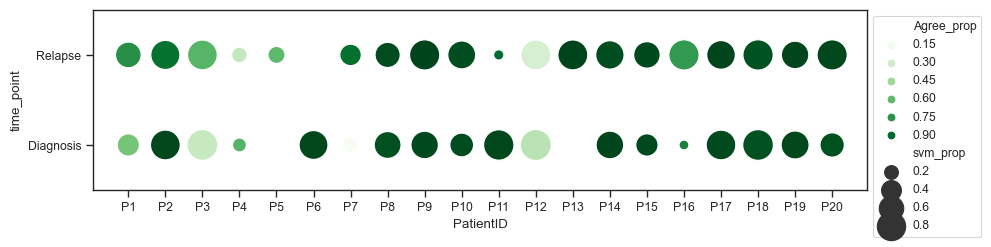

In [12]:
plt.figure(figsize=(10,2.5))
sns.scatterplot(data=all_frac[(all_frac["Prediction"]=="Blast")& (all_frac["time_point"]!="EOI I")], 
                x="PatientID", y="time_point", size="svm_prop", hue="Agree_prop", palette="Greens",
               sizes=(1,500))
plt.legend(bbox_to_anchor=(1,1))
plt.ylim(-.5, 1.5)
plt.tight_layout()
# plt.savefig("/Users/adr/Box/iPC_AML/Documents/Manuscript/Figures/Figure2/bubble_plot_svm_and_of_which_CD45low_blast_fraction.pdf")


# Compute agreement scores

In [13]:
annotated_bool = (run_meta["cell_type"]=="Blast") | (run_meta["time_point"]=="EOI I")
run_meta.loc[annotated_bool, "Annotation"] = ["Blast" if ct=="Blast" else "Healthy" for ct in run_meta.loc[annotated_bool, "cell_type"]] 

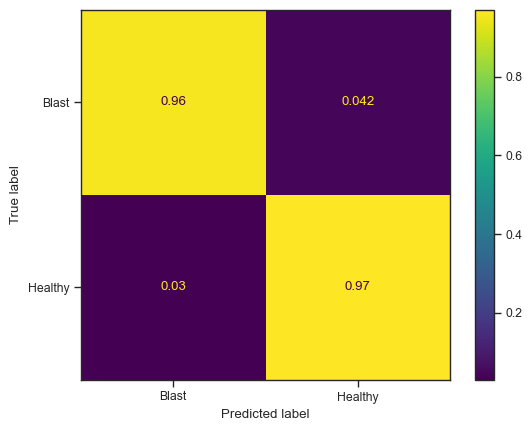

In [14]:
ConfusionMatrixDisplay.from_predictions(run_meta.loc[annotated_bool, "Annotation"], 
                                       run_meta.loc[annotated_bool, "Prediction"],
                                       normalize="true")

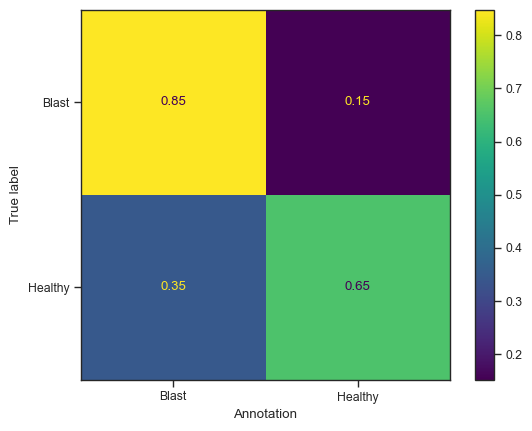

In [15]:
ConfusionMatrixDisplay.from_predictions(run_meta.loc[annotated_bool, "Annotation"], 
                                       run_meta.loc[annotated_bool, "CD45_pred"],
                                       normalize="true")
plt.xlabel("CD45low gate")
plt.xlabel("Annotation")
plt.savefig("/Users/adr/Box/iPC_AML/Documents/Manuscript/Figures/Suppl_Figure2/CD45low_gate_confusion_matrix.pdf")

Text(0.5, 0, 'CD45low prediction')

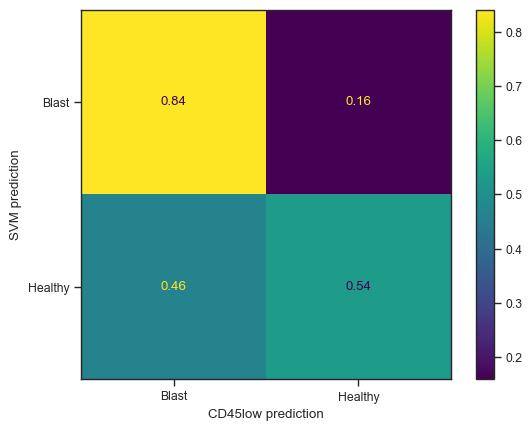

In [16]:
ConfusionMatrixDisplay.from_predictions(run_meta.loc[annotated_bool, "Prediction"], 
                                       run_meta.loc[annotated_bool, "CD45_pred"],
                                       normalize="true")
plt.ylabel("SVM prediction")
plt.xlabel("CD45low prediction")

Text(0, 0.5, 'CD45low prediction')

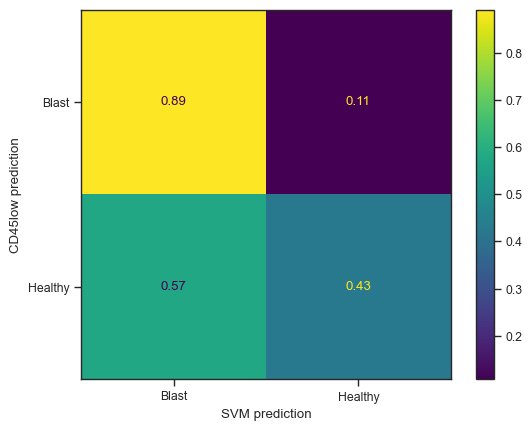

In [17]:
ConfusionMatrixDisplay.from_predictions(run_meta.loc[annotated_bool, "CD45_pred"], 
                                       run_meta.loc[annotated_bool, "Prediction"],
                                       normalize="true")
plt.xlabel("SVM prediction")
plt.ylabel("CD45low prediction")

In [18]:
print(accuracy_score(run_meta.loc[annotated_bool, "Annotation"], run_meta.loc[annotated_bool, "Prediction"]))
print(balanced_accuracy_score(run_meta.loc[annotated_bool, "Annotation"], run_meta.loc[annotated_bool, "Prediction"]))


0.9600958120404434
0.96437383909873


In [19]:
print(accuracy_score(run_meta.loc[annotated_bool, "Annotation"], run_meta.loc[annotated_bool, "CD45_pred"]))
print(balanced_accuracy_score(run_meta.loc[annotated_bool, "Annotation"], run_meta.loc[annotated_bool, "CD45_pred"]))

0.8185821917481403
0.7505390340927764
